# Dependências

In [3]:
#Python 3.12.4
!pip install -r requirements.txt

In [2]:
!pip freeze > requirements.txt

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Descrição dos datasets:

## EPL Standings 2000-2022.csv

Esse dataset reflete as classificações da Premier League, das temporadas a partir dos anos 200 até o ano de 2018.

Descrição das colunas:

* _**Season**_: temporada referente.
* _**Pos**_: posição da qual o time da linha terminou na temporada.
* _**Team**_: o nome do time referente a campanha da linha.
* _**Pld**_: partidas jogadas.
* _**W**_: vitórias.
* _**L**_: derrotas.
* _**D**_: empates.
* _**GF**_: gols feitos.
* _**GA**_: gols sofridos.
* _**GD**_: saldo de gols (GF-GA).
* _**Pts**_: total de pontos feitos.
* _**Qualification or relegation**_: status do qual o time terminou a competição (i.e. classificou para champions, rebaixado a segunda divisão ...)

## all_players.csv

Esse dataset reflete alguns dados de jogadores que com muita probabilidade estavam na Premier League, de 2015 a 2018. (Esses dados foram coletados do jogo FIFA).

O intuito é incorporar os dados de classificação (nota), idade e valor médio de mercado de transferência nos modelos de classificação.

Descrição das colunas:

* _**Year**_: ano do FIFA referente.
* _**short_name**_: nome curto do jogador em questão.
* _**club_name**_: o nome do time ao qual o jogador estava atuando.
* _**overall**_: nota do jogador de 0 a 100.
* _**value_eur**_: valor do jogador, em euros, de mercado.
* _**age**_: idade do jogador em questão.

## final_dataset.csv

# DF com tabelas de pontos corridos da PL

In [4]:
#lendo df de posição na tabela
# descrição: https://www.kaggle.com/datasets/quadeer15sh/premier-league-standings-11-seasons-20102021?resource=download
standings = pd.read_csv("EPL Standings 2000-2022.csv")
standings.head()

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
0,2000-01,1,Manchester United,38,24,8,6,79,31,48,80,Qualification for the Champions League first g...
1,2000-01,2,Arsenal,38,20,10,8,63,38,25,70,Qualification for the Champions League first g...
2,2000-01,3,Liverpool,38,20,9,9,71,39,32,69,Qualification for the Champions League third q...
3,2000-01,4,Leeds United,38,20,8,10,64,43,21,68,Qualification for the UEFA Cup first round[a]
4,2000-01,5,Ipswich Town,38,20,6,12,57,42,15,66,Qualification for the UEFA Cup first round[a]


In [5]:
# Análise Descritiva
print(standings.describe())

              Pos    Pld           W           D           L          GF  \
count  440.000000  440.0  440.000000  440.000000  440.000000  440.000000   
mean    10.500000   38.0   14.261364    9.477273   14.261364   50.863636   
std      5.772845    0.0    5.987638    2.856385    5.548080   15.778205   
min      1.000000   38.0    1.000000    2.000000    0.000000   20.000000   
25%      5.750000   38.0   10.000000    7.000000   10.000000   40.000000   
50%     10.500000   38.0   13.000000    9.000000   15.000000   47.000000   
75%     15.250000   38.0   18.000000   11.000000   18.000000   60.000000   
max     20.000000   38.0   32.000000   17.000000   29.000000  106.000000   

               GA         GD         Pts  
count  440.000000  440.00000  440.000000  
mean    50.863636    0.00000   52.240909  
std     12.893450   26.02627   17.097234  
min     15.000000  -69.00000   11.000000  
25%     42.000000  -19.00000   40.750000  
50%     51.000000   -6.00000   48.000000  
75%     59.000

# IC's para cada posição com base na coluna.

A ideia é ter um resultado de um Intervalo de confiança de 95% para os time que estão em cada posição para os valores de uma coluna.

Exemplo:
  Caso usemos a coluna de gols feitos.
  Qual o intervalo de gols feitos que os times de cada posição (0-20) fazem com 95% de chance.

In [6]:
column = "GF" #gols sofridos

def get_column_values_for_years(df, column) -> list:
  """Returns a list where each element represents the values\n
     for all years for the position = idx+1."""
  df = df.copy()

  df = df[["Pos", "Season", column]]

  matrix_of_colum_values = [standings[standings["Pos"] == pos][column].values
                            for pos in range(1,21)]

  return matrix_of_colum_values

def bootstrap_to_compute_IC(values, iters=10000) -> list:
  """Returns a list of INTERVALOS DE CONFIANÇA.\n"""
  bootstrap = [[] for _ in range(20)]

  for _ in range(iters):
    for idx, items in enumerate(values):
      sample = np.random.choice(values[idx], 20, replace=True)
      bootstrap[idx].append( sample.mean() )

  return bootstrap

def compute_ICs(bootstrap) -> list:
  ICs = []

  for item in bootstrap:
    ICs.append([np.percentile(item, 2.5), np.percentile(item, 97.5)])

  return ICs

values = get_column_values_for_years(standings, column)
bstrap = bootstrap_to_compute_IC(values)
ICs = compute_ICs(bstrap)
ICs

[[78.65, 88.4],
 [72.95, 83.50124999999998],
 [66.05, 73.1],
 [63.55, 70.35],
 [56.95, 63.45124999999999],
 [55.2, 61.45],
 [49.3, 57.1],
 [47.8, 53.05],
 [45.25, 50.2],
 [43.85, 48.9],
 [42.35, 49.6],
 [43.6, 48.0],
 [39.95, 44.0],
 [39.65, 45.75],
 [39.29875, 44.8],
 [38.2, 43.3],
 [37.25, 41.5],
 [35.0, 40.45],
 [33.9, 39.8],
 [27.55, 33.95]]

Baseado nos intervalos de confiança expressos acima, podemos tirar algumas conclusões baseadas no número de gols feitos:
1. Um time que marca pelo menos 41 gols tem 95% de chance de não ser rebaixado
2. Para se classificar para a Champions League, uma equipe deve marcar no mínimo 64 gols, uma média de 1.68 gols por partida
3. O campeão marca cerca de 5 gols a mais que o segundo colocado

# Alguns gráficos relevantes

In [7]:
column = "Pts"
values = get_column_values_for_years(standings, column)
bstrap = bootstrap_to_compute_IC(values)

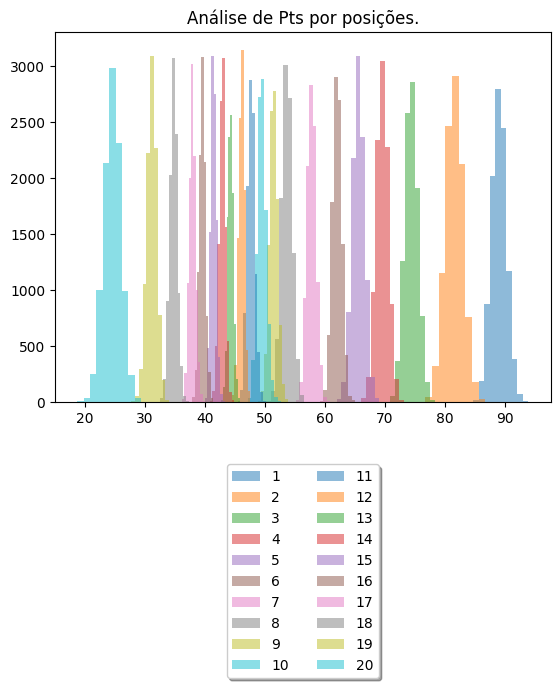

In [8]:
# gráfico do bootstrap.
for idx, item in enumerate(bstrap):
  plt.hist(item, label=str(idx+1), alpha=.5)
plt.title(f"Análise de {column} por posições.")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

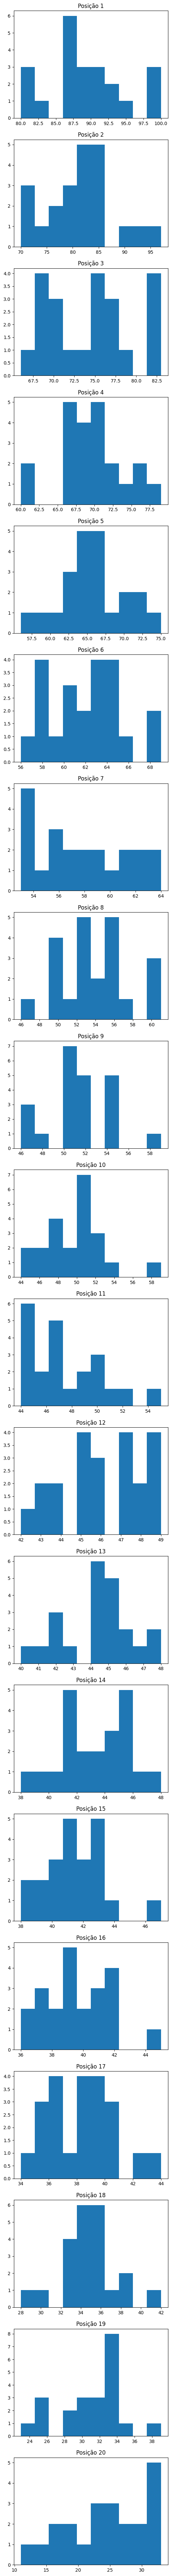

In [9]:
# gráficos dos dados brutos.
column = "Pts"
values = get_column_values_for_years(standings, column)

fig, ax = plt.subplots(20, figsize=(6,100))

for idx, item in enumerate(values):
  ax[idx].set_title(f"Posição {idx+1}")
  ax[idx].hist(item, label=str(idx+1))

Na temporada de 2018-19 da Premier League, tivemos dois casos muito intrigantes no topo da tabela. Os dois primeiros colocados fugiram muito do esperado, com o campeão Manchester City fazendo 98 pontos, e o segundo colocado Liverpool chegando a 97 pontos.

A probabilidade de tal feito é muito pequena, uma vez que analisando o bootstrap para as duas posições (apresentado abaixo), vemos que chegar aos 98 e 97 pontos é quase impossível caso fosse algo dependente apenas da chance.

Text(0.5, 1.0, 'Bootstrap de pontos de primeiros e segundos colocados')

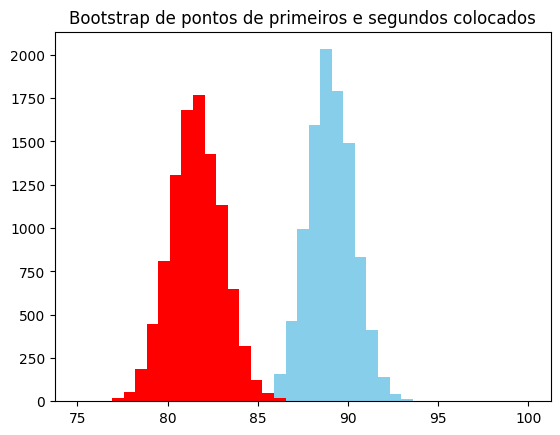

In [10]:
bins = np.linspace(75, 100, 40)
plt.hist(bstrap[0], label="1", bins=bins, color="skyblue")
plt.hist(bstrap[1], label="2", bins=bins, color="red")
plt.title("Bootstrap de pontos de primeiros e segundos colocados")

Com a análise do gráfico, podemos identificar que uma pontuação de 98 pontos para o primeiro colocado e 97 pontos para o segundo se caracterizam como grandes *outliers*, visto que ambas ocorrem em menos de 2.5% dos casos.

In [11]:
print(np.percentile(bstrap[0], 97.5))
print(np.percentile(bstrap[1], 97.5))

91.55
84.45124999999999


A matriz de correlação nos ajuda a visualizar como diferentes aspectos do desempenho de um time estão relacionados. Por exemplo, um saldo de gols (GD) mais alto está fortemente correlacionado com mais pontos (Pts), sugerindo que tanto marcar muitos gols quanto sofrer poucos são importantes para o sucesso na competição.

In [12]:
# Correlação
correlation_matrix = standings[['GF', 'GA', 'GD', 'Pts']].corr()
print(correlation_matrix)

           GF        GA        GD       Pts
GF   1.000000 -0.644366  0.925461  0.898749
GA  -0.644366  1.000000 -0.886043 -0.849168
GD   0.925461 -0.886043  1.000000  0.965538
Pts  0.898749 -0.849168  0.965538  1.000000


Com gráficos de dispersão, podemos visualizar melhor essas correlações. A relação entre as métricas de desempenho ofensivo e defensivo (gols marcados, gols sofridos e saldo de gols) e a pontuação do time ficam evidentes. Eles ajudam a identificar padrões e a entender melhor como essas variáveis estão correlacionadas com o desempenho geral.

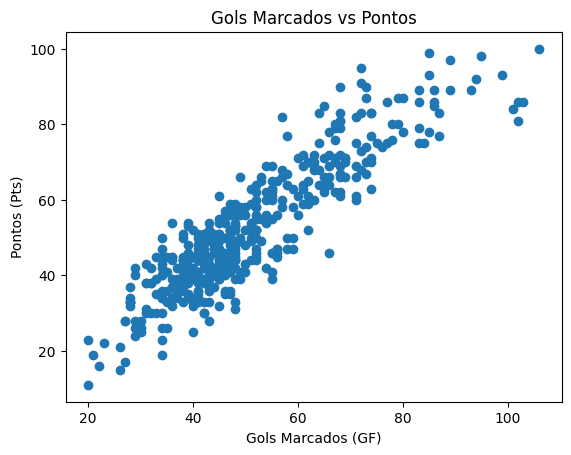

In [13]:
# Gráfico de Dispersão
plt.scatter(standings['GF'], standings['Pts'])
plt.title('Gols Marcados vs Pontos')
plt.xlabel('Gols Marcados (GF)')
plt.ylabel('Pontos (Pts)')
plt.show()

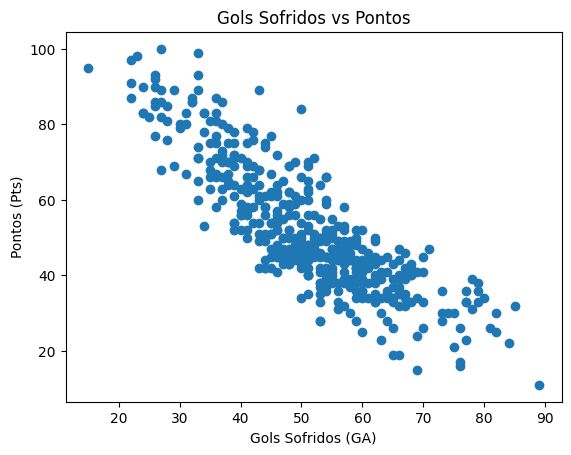

In [14]:
plt.scatter(standings['GA'], standings['Pts'])
plt.title('Gols Sofridos vs Pontos')
plt.xlabel('Gols Sofridos (GA)')
plt.ylabel('Pontos (Pts)')
plt.show()

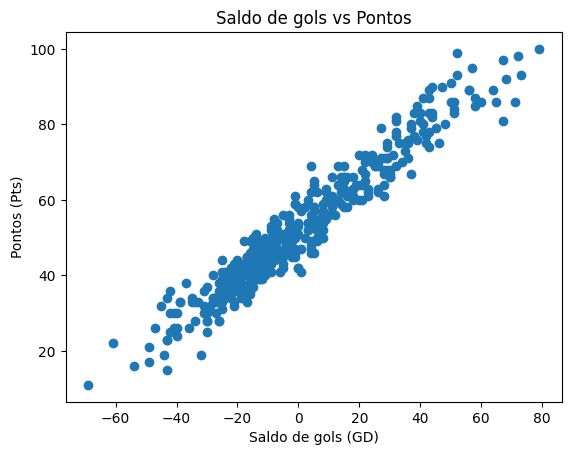

In [15]:
plt.scatter(standings['GD'], standings['Pts'])
plt.title('Saldo de gols vs Pontos')
plt.xlabel('Saldo de gols (GD)')
plt.ylabel('Pontos (Pts)')
plt.show()

Podemos categorizar os times entre campeões, rebaixadose meio da tabela, e assim, visualizar qual a pontuação média de cada categoria. Com isso, é possível fazer uma previsão sobre o time com base na sua pontuação.

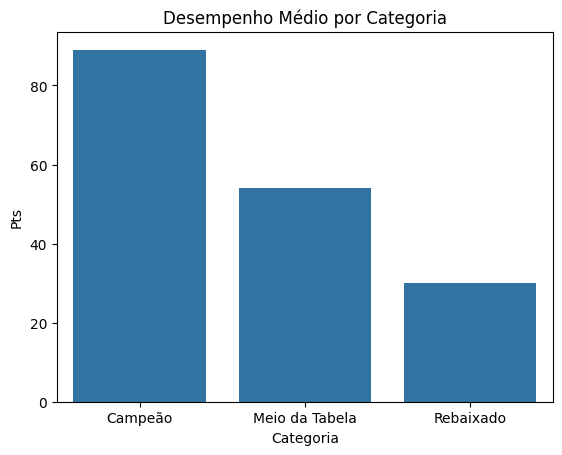

In [16]:
# Cria uma coluna para as categorias: campeão, rebaixado, meio da tabela
condicoes = [
    (standings['Pos'] == 1),
    (standings['Pos'] >= 18)
]
opcoes = ['Campeão', 'Rebaixado']
standings['Categoria'] = np.select(condicoes, opcoes, default='Meio da Tabela')

# Calcula médias de desempenho
performace = standings.groupby('Categoria')['Pts'].mean().reset_index()

# Visualiza os resultados
sns.barplot(x='Categoria', y='Pts', data=performace)
plt.title('Desempenho Médio por Categoria')
plt.show()

# Perguntas que deixamos na primeira etapa:

É possível prever quem será o campeão de uma competição baseado no desempenho de competições anteriores?

Ser rebaixado/campeão/meio de tabela é um indicador relevante para o futuro de uma equipe?

Se a ofensividade/defensividade, ou qualquer outra característica tática marcante de um time, é um indicador relevante para o futuro da equipe?

# O que vai ser avaliado na segunda parte.

Fez análises que ajudam a entender o efeito das variáveis dependentes na resposta?

Gráficos claros e contam uma história para o resultado final?

Executou testes de hipótese/ICs corretamente?

Perguntas 1 e 2. É possível perceber atráves da computação dos e da observação dos ICs e dos gráficos, que existem comportamentos e estatísticas esperadas para times de cada posição.

Precisamos agora encontrar uma maneira usar os resultados antigos para prever comportamento (próx etapa), usando regressão.

Pergunta 3. Atráves dos mesmos conceitos empregados na duas primeiras perguntas, podemos usar a tabela de partidas que encontramos para enriquecer o futuro modelo de regressão.

# Parte final (Terceira parte)

## Classifição para estimar posição geral (G4*, Z4*, meio de tabela).

Muito embora, devido ao campeonato brasileiro, a gente conheça como G4 e Z4, nossos dados são contextualizados, i.e. são referentes a Premier League. Ou seja, são rebaixados somente dois times (equivalente ao Z4), uma quantia variável de times vão para  a Champions League (equivalente ao G4) ao longo dos anos.

Para essa análise, consideraremos o G4 na sua definição padrão e o que seria o "Z2".

In [17]:
condicoes = [
    (standings['Pos'] <= 4),
    (standings['Pos'] >= 18)
]
opcoes = ['G4', 'Z2']
standings['Categoria'] = np.select(condicoes, opcoes, default='Meio da Tabela')

In [18]:
x = standings[['GF', 'GA', "W", "D"]]
y = standings['Categoria']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
def use_model_to_predict(team_name: str, seasons_before:int=3) -> float:
    """Function that uses the model to predict the category of a team.\n
       team_name: str - The name of the team.\n
       seasons_before: int - The number of seasons to consider.\n
       return: float - The prediction."""
    
    # getting only valuable info.
    team_info = standings[standings["Team"] == team_name][['GF', 'GA', "W", "D", "Season"]]

    # getting the last X seasons.
    seasons = standings["Season"].unique().tolist()
    seasons.sort()
    seasons = seasons[-seasons_before:]

    # getting the mean of the valuable info from the last X seasons.
    team_info = team_info[team_info["Season"].isin(seasons)][['GF', 'GA', "W", "D"]]

    # predicting
    return model.predict(team_info.mean().values.reshape(1, -1))

use_model_to_predict("Leicester", 3)

C:\Users\freit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['Meio da Tabela'], dtype=object)

## Pegando e tratando dados de partidas.

In [170]:
matches = pd.read_csv("final_dataset.csv")
matches.dropna(inplace=True)
matches["Year"] = matches["Date"].apply(lambda x: 2000+int(x.split("/")[2]))

In [53]:
from fuzzywuzzy import fuzz

def compare_team_names(name1, name2):
    similarity_score = fuzz.ratio(name1, name2)
    return similarity_score / 100

teams_PremierLeague = standings["Team"].unique().tolist()

all_players = pd.DataFrame()
for i in range(15, 23):
    players = pd.read_csv(f"archive/players_{i}.csv")
    teams_in_players_dataset = players["club_name"].unique().tolist()

    # comparar os nomes dos times por similaridade.
    # similiaridade > 0.74 -> mesmo time, consideramos que jogador esta na PL.
    results = []
    mapping = {}
    for team1 in teams_in_players_dataset:
        for team2 in teams_PremierLeague:
            if not isinstance(team1, str): continue

            if compare_team_names(team1.lower(), team2.lower()) > 0.74:
                mapping[team1] = team2
                results.append(team1)

    results = list(set(results))

    # somente jogadores da PL.
    players = players[players["club_name"].isin(results)]
    
    # definindo o ano.
    players["Year"] = i+2000
    
    #garantindo que os nomes dos times são iguais
    players["club_name"] = players["club_name"].apply(lambda x: mapping[x] if x in mapping else x)
    
    # selecionando colunas.
    players = players[["Year", "short_name", "club_name", "overall", "value_eur", "age"]]
    
    # concatenando.
    all_players = pd.concat([all_players, players])
    
all_players.to_csv("all_players.csv", index=False)

C:\Users\freit\AppData\Local\Temp\ipykernel_14180\2384618896.py:11: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv(f"archive/players_{i}.csv")


76.72058823529412


C:\Users\freit\AppData\Local\Temp\ipykernel_14180\2384618896.py:11: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv(f"archive/players_{i}.csv")


77.59420289855072
79.12987012987013


C:\Users\freit\AppData\Local\Temp\ipykernel_14180\2384618896.py:11: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv(f"archive/players_{i}.csv")


79.18666666666667
78.72093023255815
78.14942528735632
78.41573033707866
80.6103896103896


C:\Users\freit\AppData\Local\Temp\ipykernel_14180\2384618896.py:11: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv(f"archive/players_{i}.csv")


In [ ]:
# dataset de partidas
from datetime import datetime

def convert_to_mmddyy(date_str):
    for fmt in ('%m/%d/%y', '%m/%d/%Y', '%d/%m/%y', '%d/%m/%Y'):
        try:
            date_obj = datetime.strptime(date_str, fmt)
            return date_obj.strftime('%m/%d/%y')
        except ValueError:
            continue
    raise ValueError(f"date format for '{date_str}' not recognized")

matches = pd.read_csv("final_dataset.csv")
matches.dropna(inplace=True)
matches['Date'] = matches['Date'].apply(convert_to_mmddyy)
matches["Year"] = matches["Date"].apply(lambda x: 2000+int(x.split("/")[2]))
matches = matches[matches["Year"] > 2001] # tirando dados que tem poucas infos.
matches.head()